# 

# Map of the New Global Heat Flow Database
This notebook plots a global* map of the filtered heat flow data. Specific regions of interest,
where the *random global $R$-disk covering* of notebook `03-Gamma-Conjugate-Prior-Parameters`
contains disks, are plotted as tiles on the global map in more detail and less distorted.
Coordinates between the tiles are warped by solving the diffusion equation on projected coordinates.


<font size="1">*) Some parts to the North/South/East/West are missing where there are no heat flow data.</font>

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import numpy as np
import scipy.sparse as sp
from pickle import Unpickler
from pyproj import Proj, Geod
from cache import cached_call
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from flottekarte import Map, GeoJSON
from scipy.sparse.linalg import spsolve
from matplotlib.collections import PolyCollection
from matplotlib.patches import Polygon as MPolygon, Circle

In [3]:
from matplotlib import rcParams
rcParams["text.usetex"] = False
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 10

## Load Results From Other Notebooks
### 03-Gamma-Conjugate-Prior-Parameters

In [4]:
with open('results/03-gamma-conjugate-prior-results.json','r') as f:
    conjugate_prior_results = json.load(f)
    
cgp_lola = np.stack(([c[0][0] for c in conjugate_prior_results],
                     [c[0][1] for c in conjugate_prior_results]), axis=1)

### 01-Load-and-filter-NGHF

In [5]:
HEAT, LON, LAT = np.load('data/heat-flow-selection-mW_m2.npy')

### 02-Study-Area-Geometry

In [6]:
with open('export/02-Geometry.pickle','rb') as f:
    geometry = Unpickler(f).load()

## Tiled Map
Here, we create a global map from a tiling of local maps. Inbetween the local maps,
the global map is warped by solving the diffusing equation for coordinates given
the boundary conditions at the local map boundaries.

In [7]:
proj_strings = [
    "+proj=lcc +lon_0=-113 +lat_0=41 +lat_1=33 +lat_2=50",
    "+proj=lcc +lon_0=-76.5 +lat_0=0.0 +lat_1=-10.0 +lat_2=11",
    "+proj=lcc +lon_0=5 +lat_0=50 +lat_1=40 +lat_2=60",
    "+proj=lcc +lon_0=40 +lat_0=0 +lat_1=-10 +lat_2=11",
    "+proj=lcc +lon_0=88 +lat_0=42 +lat_1=36 +lat_2=48",
    "+proj=lcc +lon_0=119 +lat_0=41 +lat_1=37 +lat_2=45",
    "+proj=lcc +lon_0=77 +lat_0=14 +lat_1=10 +lat_2=20",
    "+proj=lcc +lon_0=143 +lat_0=-38 +lat_1=-43 +lat_2=-35",
    "+proj=lcc +lon_0=-48 +lat_0=-26 +lat_1=-24 +lat_2=-28",
    "+proj=lcc +lon_0=42 +lat_0=39 +lat_1=33 +lat_2=-47",
    "+proj=lcc +lon_0=75 +lat_0=62 +lat_1=57 +lat_2=63",
]

xlims = [
    (-1.1e6, 1.2e6),
    (-6e5, 1e5),
    (-1.4e6, 1.4e6),
    (-6e5, 5e5),
    (-5e5, 5e5),
    (-1e6, 8e5),
    (-7e5, 8e5),
    (-5e5, 5e5),
    (-5e5, 5e5),
    (-8e5, 8e5),
    (-3e5, 3e5),
]
ylims = [
    (-1e6, 1e6),
    (-3e5, 3e5),
    (-2e6, 2e6),
    (-4e5, 3e5),
    (-7e5, 5e5),
    (-1e6, 1e6),
    (-7e5, 8e5),
    (-5e5, 5e5),
    (-5e5, 5e5),
    (-1.1e6, 1e6),
    (-3e5, 3e5),
]

In [8]:
xlims = np.array(xlims)
ylims = np.array(ylims)

Coast lines from the [GSHHG](https://www.soest.hawaii.edu/pwessel/gshhg/) (Wessel & Smith, 1996). The GeoJSONs required for the following code to work can be generated from the ESRI shapefile versions of the GSHHG,
for instance using QGIS.

In [9]:
gshhs_l_1 = [GeoJSON('data/GSHHS_l_1.geojson', ps, xlim=xl, ylim=yl)
             for ps,xl,yl in zip(proj_strings,xlims,ylims)]

/home/phd/.local/lib/python3.10/site-packages/flottekarte/data/geojson.py:89: UserWarning: In GeoJSON, polygon selection is currently point selection. This can cause polygons not to be selected if they completely contain the x and y extents.
  warn("In GeoJSON, polygon selection is currently point selection. "
/home/phd/.local/lib/python3.10/site-packages/flottekarte/data/geojson.py:89: UserWarning: In GeoJSON, polygon selection is currently point selection. This can cause polygons not to be selected if they completely contain the x and y extents.
  warn("In GeoJSON, polygon selection is currently point selection. "
/home/phd/.local/lib/python3.10/site-packages/flottekarte/data/geojson.py:89: UserWarning: In GeoJSON, polygon selection is currently point selection. This can cause polygons not to be selected if they completely contain the x and y extents.
  warn("In GeoJSON, polygon selection is currently point selection. "
/home/phd/.local/lib/python3.10/site-packages/flottekarte/data/g

In [10]:
gshhs_c_1 = GeoJSON('data/GSHHS_c_1_selected.geojson', f'+proj=eqc +R={180.0/np.pi}')

Distribute the relevant data across the local regions:

In [11]:
X = []
Y = []
heat = []
gcp_xy = []
gcp_plotted = np.zeros(cgp_lola.shape[0], dtype=bool)
for ps,xl,yl in zip(proj_strings, xlims, ylims):
    x,y = Proj(ps)(LON, LAT)
    mask = (x >= xl[0]) & (x <= xl[1]) & (y >= yl[0]) & (y <= yl[1])
    X.append(x[mask])
    Y.append(y[mask])
    heat.append(HEAT[mask])
    
    # Gamma conjugate prior results:
    x,y = Proj(ps)(cgp_lola[:,0], cgp_lola[:,1])
    mask = (x >= xl[0]) & (x <= xl[1]) & (y >= yl[0]) & (y <= yl[1])
    gcp_plotted |= mask
    gcp_xy.append((x[mask], y[mask]))

if not np.all(gcp_plotted):
    raise RuntimeError("Not all GCP results plotted!")

Generate the coordinate diffusion matrix:

In [12]:
def generate_diffusion_matrix_vector(x_fig, y_fig, Dx, Dy, xdata, ydata, londata, latdata):
    """
    Solve diffusion equation on the coordinate grid.
    """
    # Layout of grid:
    # (nx,ny)
    nx = x_fig.size
    ny = y_fig.size
    n = nx*ny
    A = sp.lil_matrix((n,n))
    v_lon = np.zeros(n)
    v_lat = np.zeros(n)
    dx = Dx / (nx-1)
    dy = Dy / (ny-1)
    
    # In which bin do the data fall?
    data_indices = dict()
    for k,(x,y) in enumerate(zip(xdata,ydata)):
        i = min(max(round(nx*x),0),nx-1)
        j = min(max(round(ny*y),0),ny-1)
        if (i,j) not in data_indices:
            data_indices[(i,j)] = [k]
        else:
            data_indices[(i,j)].append(k)
    
    idx2 = 1.0 / dx**2
    idy2 = 1.0 / dy**2
    for k in range(n):
        i = k // ny
        j = k % ny
        # Proceed depending on whether we are in a constrained
        # point or not:
        if (i,j) in data_indices:
            # External boundary:
            if (i,j) in data_indices:
                A[k,k] = 1.0
                loda_ij = [londata[l] for l in data_indices[(i,j)]]
                lada_ij = [latdata[l] for l in data_indices[(i,j)]]
                v_lon[k] = sum(loda_ij) / len(loda_ij)
                v_lat[k] = sum(lada_ij) / len(lada_ij)

        elif i == 0 or i == nx-1 or j == 0 or j == ny-1:
            # We are on the boundary. Fixed value boundary condition!
            A[k,k] = 1.0

            # Now set the boundary conditions.
            v_lon[k] = -180.0 + 360.0 / (nx-1) * i
            v_lat[k] =  -90.0 + 180.0 / (ny-1) * j
            if i == 0:
                v_lon[k] = -180.0
            elif i == nx-1:
                v_lon[k] = 180.0
            if j == 0:
                v_lat[k] = -90.0
            elif j == ny-1:
                v_lat[k] = 90.0

        else:
            # Not on x or y boundary.
            A[k,k] = -2 * (idx2 + idy2);
            A[k,k-ny] = idx2
            A[k,k+ny] = idx2
            A[k,k-1]  = idy2
            A[k,k+1]  = idy2
        
    return A.tocsc(), v_lon, v_lat    

Utility code for plotting:

In [13]:
def reproject_xy(x, y, ax_xlim, ax_ylim, ax_pos_x0_x1_y0_y1):
    """
    Reprojects coordinates from the axis coordinates to
    the global figure coordinates.
    """
    x0,x1,y0,y1 = ax_pos_x0_x1_y0_y1
    ax_pos = (x0, y0, x1-x0, y1-y0)
    rel_ax_x = (x-ax_xlim[0]) / (ax_xlim[1] - ax_xlim[0])
    rel_ax_y = (y-ax_ylim[0]) / (ax_ylim[1] - ax_ylim[0])
    rel_fig_x = ax_pos[0] + rel_ax_x * ax_pos[2]
    rel_fig_y = ax_pos[1] + rel_ax_y * ax_pos[3]
    return rel_fig_x, rel_fig_y

def construct_coordinate_constraints(ax_pos_x0_x1_y0_y1, xlim_real, ylim_real, xlims, ylims, proj_strings):
    """
    
    """
    m = 50
    rel_x = []
    rel_y = []
    lon = []
    lat = []
    for i in range(len(axes)):
        x_i = np.concatenate((np.linspace(*xlims[i,:],m+1)[:-1], np.ones(m)*xlims[i,1],
                              np.linspace(*xlims[i,:],m+1)[:-1][::-1], np.ones(m)*xlims[i,0]))
        y_i = np.concatenate((np.ones(m)*ylims[i,0], np.linspace(*ylims[i,:],m+1)[:-1],
                              np.ones(m)*ylims[i,1], np.linspace(*ylims[i,:],m+1)[:-1][::-1]))
        rel_x_i, rel_y_i = reproject_xy(x_i, y_i, xlim_real[i,:], ylim_real[i,:], ax_pos_x0_x1_y0_y1[i,:])
        rel_x.append(rel_x_i)
        rel_y.append(rel_y_i)
        lon_i, lat_i = Proj(proj_strings[i])(x_i, y_i, inverse=True)
        lon.append(lon_i)
        lat.append(lat_i)

    return np.concatenate(rel_x), np.concatenate(rel_y), np.concatenate(lon), np.concatenate(lat)


def solve_diffusion_system(xg_rel, yg_rel, figwidth, figheight, rel_x, rel_y, fig_lon, fig_lat):
    """
    Assemble the diffusion system and solve it.
    """
    nx = xg_rel.size
    ny = yg_rel.size
    A, v_lon, v_lat = cached_call(generate_diffusion_matrix_vector, xg_rel, yg_rel,
                                  figwidth, figheight, rel_x, rel_y, fig_lon, fig_lat)
    lon_grid_diff = spsolve(A,v_lon).reshape((nx, ny))
    lat_grid_diff = spsolve(A,v_lat).reshape((nx, ny))
    return lon_grid_diff, lat_grid_diff


def project_polygon(multipolygons_lola, axes_x0_x1_y0_y1, xlims, ylims, xlim_real, ylim_real, proj_strings,
                    figwidth, figheight, lon_min, lon_max, lat_min, lat_max, nx=200, ny=100):
    """
    This function projects the coordinates of a set of polygons to the warped
    coordinate space of the background global axis. It performs the following steps:
       1) construct the coordinate constraints from the local maps
          in relative coordinates of the global map.
       2) Create an affine mapping of the global lon/lat range to
          the cropped section displayed in the global map. This will
          be the coordinate constraint on the global map boundary.
       3) Solve the diffusion system on a grid in the global map
       4) Index the solution points of the diffusion system in a 2D KDTree
          in global map coordinates. This tree maps lon/lat coordinates
          to relative x/y of the global map.
       5) Project each point of the multipolygons by computing the 5 nearest
          neighbors of the lon/lat coordinate and performing Nadaraya-Watson
          interpolation of the relative x/y coordinates using the geodesic
          distance and a Gaussian kernel.
    """
    rel_x, rel_y, fig_lon, fig_lat \
        = construct_coordinate_constraints(axes_x0_x1_y0_y1, xlim_real, ylim_real, xlims, ylims, proj_strings)
    
    # Scale according to latitude boundaries:
    bx = (lon_min + 180) / 360.0
    ax = (lon_max - lon_min) / 360.0
    rel_x =  ax * rel_x + bx

    by = (lat_min + 90) / 180.0
    ay = (lat_max - lat_min) / 180.0
    rel_y =  ay * rel_y + by

    xg_rel = np.linspace(0, 1, nx)
    yg_rel = np.linspace(0, 1, ny)


    xg_relg, yg_relg = np.meshgrid(xg_rel,yg_rel,indexing='ij')
    #A, v_lon, v_lat = cached_call(generate_diffusion_matrix_vector, xg_rel, yg_rel,
    #                              figwidth, figheight, rel_x, rel_y, fig_lon, fig_lat)
    #lon_grid_diff = spsolve(A,v_lon).reshape((nx, ny))
    #lat_grid_diff = spsolve(A,v_lat).reshape((nx, ny))
    lon_grid_diff, lat_grid_diff = cached_call(solve_diffusion_system, xg_rel, yg_rel,
                                               figwidth, figheight, rel_x, rel_y, fig_lon, fig_lat)


    # Populate the tree that maps projected coordinates to inverse:
    tree = KDTree(np.stack((lon_grid_diff.flat, lat_grid_diff.flat), axis=1))
    tree_x = xg_relg.flat
    tree_y = yg_relg.flat

    # Now compute the polygon coordinates:
    gshhs_c_xy = []
    geod = Geod(ellps="WGS84")
    nn = 5
    for mpoly in multipolygons_lola:
        for poly in mpoly:
            neighbors = tree.query(poly[0], nn)
            distance = np.empty((poly[0].shape[0],nn))
            for i in range(nn):
                distance[:,i] = geod.inv(poly[0][:,0], poly[0][:,1], lon_grid_diff.flat[neighbors[1][:,i]],
                                         lat_grid_diff.flat[neighbors[1][:,i]])[2]
            # Set the coordinates:
            weights = np.exp(-0.5 * distance**2 / 1e6**2)
            weights /= weights.sum(axis=1)[:,np.newaxis]
            poly_xy = np.zeros(poly[0].shape)
            poly_xy[:,0] = (weights * tree_x[neighbors[1]]).sum(axis=1)
            poly_xy[:,1] = (weights * tree_y[neighbors[1]]).sum(axis=1)
            
            # Crop back:
            poly_xy[:,0] -= bx
            poly_xy[:,0] /= ax
            poly_xy[:,1] -= by
            poly_xy[:,1] /= ay
            gshhs_c_xy.append(poly_xy)
    
    
    return gshhs_c_xy, lon_grid_diff, lat_grid_diff, (xg_rel-bx)/ax, (yg_rel - by) / ay

A matplotlib Artist for handling circles in a legend:

In [14]:
class CircleHandler:
    def __init__(self, scale=1.0):
        self.scale = scale
    
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0 = handlebox.xdescent+0.5*handlebox.width
        y0 = handlebox.ydescent + 0.5*handlebox.height

        # Radius from axis to display and then to handlebox:
        R = orig_handle.get_radius()

        # Now xy is centered in the axes.
        # Get the relative size of y axis interval in point:
        xlim = orig_handle.axes.get_xlim()
        ylim = orig_handle.axes.get_ylim()
        dy_ax_pt = 72*(ax.get_position().y1 - ax.get_position().y0) * fig.get_figheight()

        # Rescale to points:
        R *= dy_ax_pt / (ylim[1]-ylim[0])
        
        # Rescale to desired size:
        R *= self.scale
        
        patch = Circle([x0, y0], R,#R_hb,
                       facecolor=orig_handle.get_facecolor(),
                       edgecolor=orig_handle.get_edgecolor(),
                       hatch=orig_handle.get_hatch(),
                       linewidth=orig_handle.get_linewidth(),
                       transform=handlebox.get_transform()
                      )
        handlebox.add_artist(patch)
        return patch

Finally, plot the map:

construct constraints


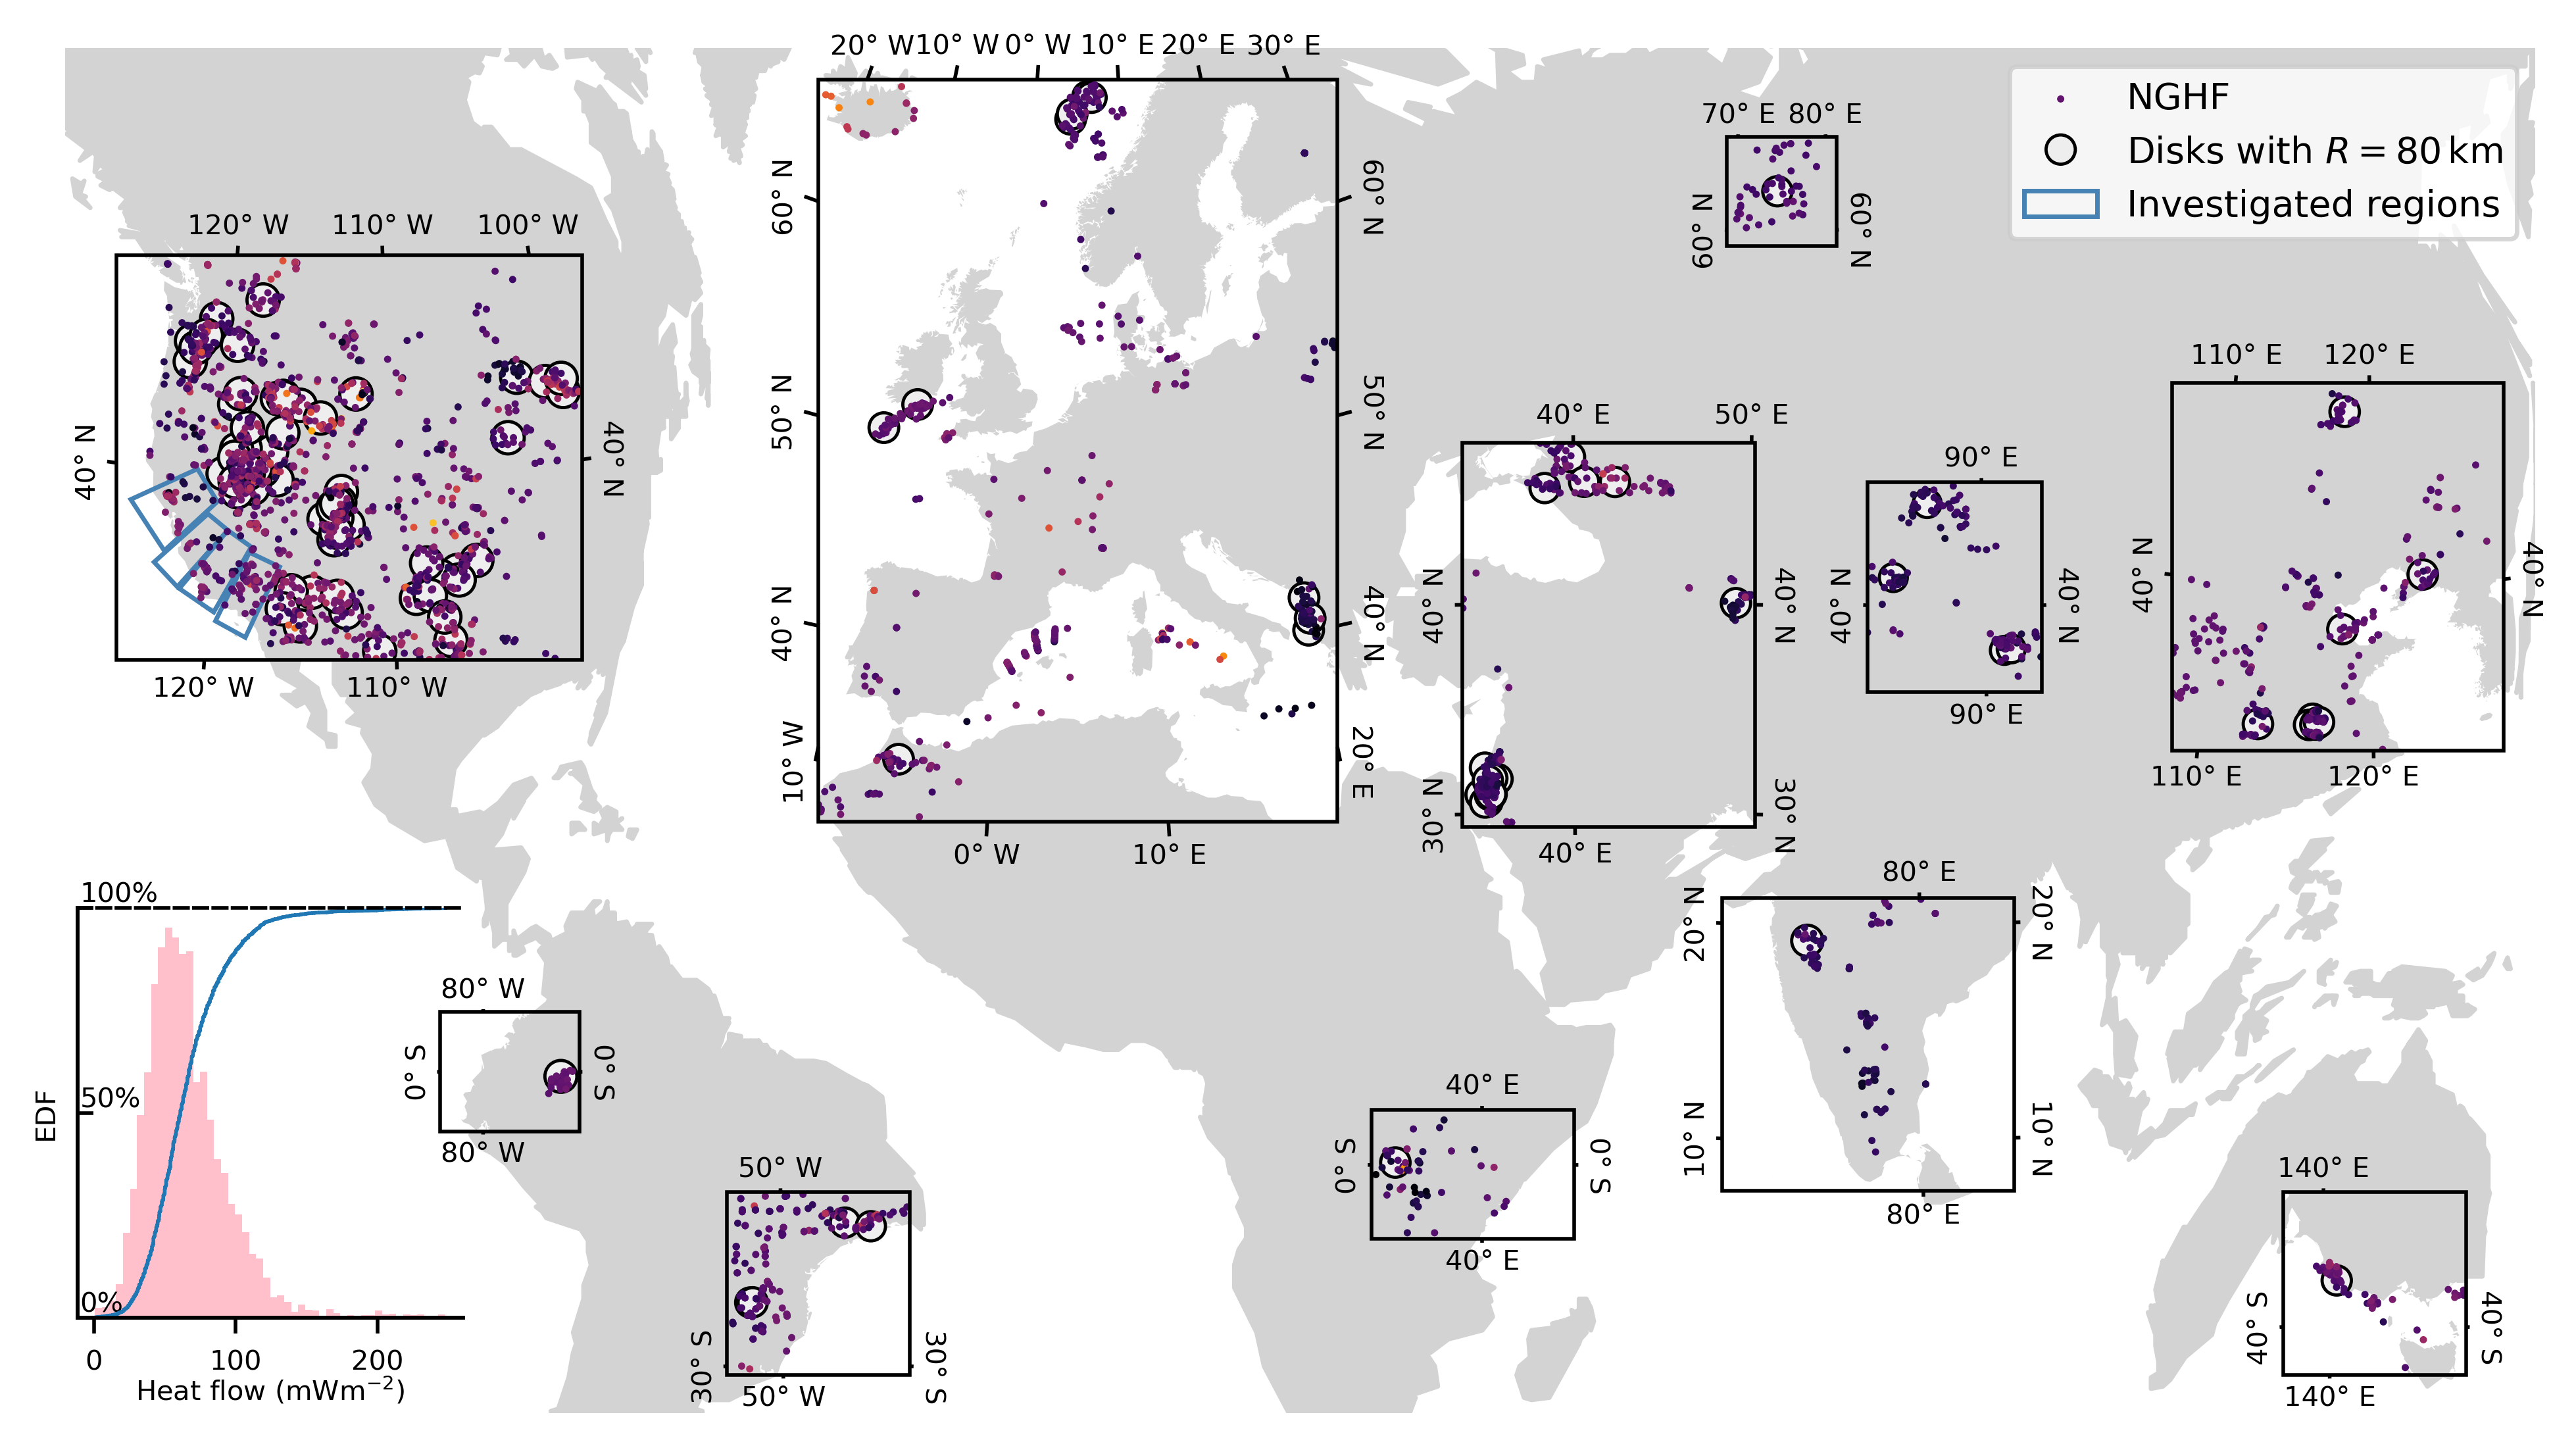

In [18]:
fig = plt.figure(figsize=(7.510,4.15), dpi=250)

# The background axis. Comment the last line to
# plot the axis splines which are useful for layouting.
ax_bg = fig.add_axes((0,0,1,1))
ax_bg.set_xlim(0,1)
ax_bg.set_ylim(0,1)
ax_bg.set_axis_off()


# Position the local maps:
ax_pos = [
    (0.00, 0.4, 0.23, 0.6),   # USA
    (0.13, 0.2, 0.1, 0.1),   # Western South America 
    (0.28, 0.4, 0.26, 0.61),    # Europe
    (0.52, 0.1, 0.1, 0.15),   # East Africa
    (0.68, 0.52, 0.17, 0.17),  # central asia
    (0.77, 0.47, 0.3, 0.3),    # China
    (0.61, 0.15, 0.24, 0.24),    # India
    (0.86, 0.02, 0.15, 0.15),   # Australia
    (0.23, 0.02, 0.15, 0.15),   # Eastern South America
    (0.51, 0.415, 0.23, 0.31),    # Europe 2
    (0.66, 0.85, 0.07, 0.09),    # Siberia
]

axes = []
for i in range(len(proj_strings)):
    ax = fig.add_axes(ax_pos[i])
    axes.append(ax)

    
# Plot the local axes:
vmin = HEAT.min()
vmax = HEAT.max()
for i,ps in enumerate(proj_strings):
    ax = axes[i]
    if i == 4 or i == 10:
        ax.add_patch(MPolygon([(xlims[i,0],ylims[i,0]), (xlims[i,1],ylims[i,0]),
                           (xlims[i,1],ylims[i,1]), (xlims[i,0],ylims[i,1])],
                          color='lightgray', zorder=0))
    else:
        ax.add_patch(MPolygon([(xlims[i,0],ylims[i,0]), (xlims[i,1],ylims[i,0]),
                           (xlims[i,1],ylims[i,1]), (xlims[i,0],ylims[i,1])],
                          color='w', zorder=0))
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])
    mp = Map(ps, ax, xlims[i], ylims[i])
    mp.add_data(gshhs_l_1[i], edgecolor='none', facecolor='lightgray')
    if len(gcp_xy[i][0]) > 0:
        for gxy in zip(*gcp_xy[i]):
            h1 = ax.add_patch(Circle(gxy, 80e3, edgecolor='k', facecolor='#eeeeee', linewidth=0.7, zorder=1))

    h0 = ax.scatter(X[i], Y[i], c=heat[i], marker='.', edgecolor='none', cmap='inferno',
                    vmin=vmin, vmax=vmax, zorder=2, s=10, rasterized=True)
    mp.plot_axes(10, fontsize=6)

# Axes boundary coordinates:
axes_x0_x1_y0_y1 = np.array([(p.x0, p.x1, p.y0, p.y1) for p in [ax.get_position() for ax in axes]])
xlim_real = np.array([ax.get_xlim() for ax in axes])
ylim_real = np.array([ax.get_ylim() for ax in axes])


# Compute the polygons:
gshhs_c_xy, lon_grid_diff, lat_grid_diff, xg_rel, yg_rel \
   = project_polygon(gshhs_c_1.multipolygons, axes_x0_x1_y0_y1, xlims, ylims, xlim_real, ylim_real,
                     proj_strings, fig.get_figwidth(), fig.get_figheight(),
                     -130.0, 170.0, -50.0, 60.0, nx=400, ny=200)


# San Andreas polygons:
proj = Proj(proj_strings[0])
for poly in geometry["selection_polygons_lola"]:
    h2 = axes[0].add_patch(MPolygon(np.stack(proj(*poly.T), axis=1), facecolor='none',
                                    edgecolor='steelblue'))

ax_bg.add_collection(PolyCollection(gshhs_c_xy, color='lightgray'));

ax_bg.legend(handles=(h0,h1,h2),
             labels=('NGHF','Disks with $R=80\,\mathrm{km}$','Investigated regions'),
             handler_map = {Circle : CircleHandler()}, fontsize=8)


# The heat flow statistics:
ax2 = fig.add_axes((0.005, 0.07, 0.156, 0.3))
ax2.tick_params(labelsize=6)
ax2.tick_params(axis='y', direction='in', pad=-0.5)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_linestyle('--')
ax2.set_xlabel('Heat flow ($\mathrm{mWm}^{-2}$)',
               fontsize=6, labelpad=0.0)
ax2.set_ylabel('EDF', fontsize=6)
ax2.step(np.sort(HEAT), (np.arange(HEAT.size)+1)/HEAT.size, linewidth=0.8)
ax2.set_ylim((0,1))
ax3 = ax2.twinx()
ax3.set_position(ax2.get_position())
ax3.get_yaxis().set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.hist(HEAT, 50, facecolor='pink', histtype='stepfilled')
ax2.set_zorder(ax3.get_zorder()+1)
ax2.set_facecolor('none')
ax2.set_yticks([0.0, 0.5, 1.0])
ax2.set_yticklabels(['0%','50%','100%'], va='bottom', ha='left')


fig.savefig('figures/04-World-Map.pdf')

## References:
> Lucazeau, F. (2019). Analysis and mapping of an updated terrestrial heat
>    flow data set. Geochemistry, Geophysics, Geosystems, 20, 4001– 4024.
>    https://doi.org/10.1029/2019GC008389
>
> Wessel, P., and W. H. F. Smith, A Global Self-consistent, Hierarchical,
>    High-resolution Shoreline Database, J. Geophys. Res., 101, 8741-8743, 1996
>    https://doi.org/10.1029/96JB00104

### License
```
A notebook to plot a global map of the heat flow data and the
random global R-disk covering.

This file is part of the REHEATFUNQ model.

Author: Malte J. Ziebarth (ziebarth@gfz-potsdam.de)

Copyright © 2019-2022 Deutsches GeoForschungsZentrum Potsdam,
            2022 Malte J. Ziebarth
            

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```